In [1]:
N=ord("D")%5+1
N

4

In [2]:
import pandas as pd

file_path = 'lab6.xlsx'

df = pd.read_excel(file_path)

print(df.head())


   N         file name image size glasses color  line width
0  1  emma-watson2.jpg    300x300           red           2
1  2   emma-watson.jpg    400x400          blue           3
2  3         draco.jpg    700x700          cian           4
3  4    longbottom.jpg    600x600       magenta           5
4  5    ron_wesley.jpg    500x500        yellow           6


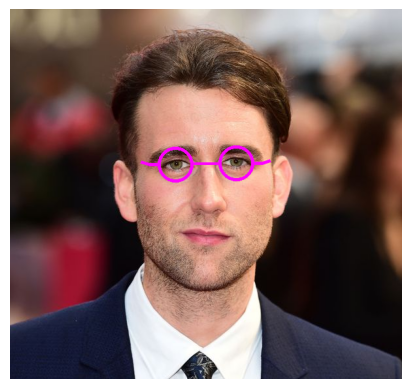

In [16]:
# Імпортуємо необхідні бібліотеки
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Шлях до Excel файлу з даними
file_path = 'lab6.xlsx'
# Зчитуємо дані з Excel файлу в DataFrame
df = pd.read_excel(file_path)

# Фільтруємо дані для варіанту 4 і отримуємо перший рядок
variant_data = df[df['N'] == 4].iloc[0]
# Отримуємо необхідні параметри для обробки з даних
file_name = variant_data['file name']
image_size = tuple(map(int, variant_data['image size'].split('x')))
glasses_color = variant_data['glasses color']
line_width = variant_data['line width']

# Формуємо шлях до зображення
img_path = f'C:\\Users\\david\\OneDrive\\Desktop\\KPI\\5 semestr\\Python\\Images\\{file_name}'
# Завантажуємо зображення за допомогою OpenCV
img = cv2.imread(img_path)

# Перетворюємо зображення в градації сірого для детекції облич
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Завантажуємо каскад Хаара для детекції облич і очей
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye_tree_eyeglasses.xml')

# Детектуємо обличчя на зображенні
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)

# Функція для додавання окулярів на обличчя
def add_glasses(img, faces, eye_cascade, glasses_color, line_width):
    # Перетворюємо зображення OpenCV на формат PIL для малювання
    pil_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(pil_img)

    # Для кожного виявленого обличчя
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]

        # Малюємо прямокутник навколо обличчя
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)  
        
        # Детектуємо очі на обличчі
        eyes = eye_cascade.detectMultiScale(roi_gray)

        # Сортуємо очі за їхнім положенням по горизонталі
        eyes = sorted(eyes, key=lambda ex: ex[0])

        # Якщо знайдено два очі
        if len(eyes) >= 2:
            eye_centers = []
            # Малюємо кола для кожного ока
            for (ex, ey, ew, eh) in eyes[:2]:
                center = (x + ex + ew // 2, y + ey + eh // 2)
                radius = ew // 2
                eye_centers.append((center, radius))
                draw.ellipse((center[0] - radius, center[1] - radius, center[0] + radius, center[1] + radius), outline=glasses_color, width=line_width)

            # Якщо два очі виявлено
            if len(eye_centers) == 2:
                (left_eye_center, left_radius), (right_eye_center, right_radius) = eye_centers

                # Обчислюємо кут між очима
                dx = right_eye_center[0] - left_eye_center[0]
                dy = right_eye_center[1] - left_eye_center[1]
                angle = np.arctan2(dy, dx)

                # Точки на мості окулярів
                left_bridge_point = (
                    int(left_eye_center[0] + left_radius * np.cos(angle)),
                    int(left_eye_center[1] + left_radius * np.sin(angle))
                )
                right_bridge_point = (
                    int(right_eye_center[0] - right_radius * np.cos(angle)),
                    int(right_eye_center[1] - right_radius * np.sin(angle))
                )

                # Малюємо міст окулярів
                draw.line([left_bridge_point, right_bridge_point], fill=glasses_color, width=line_width)

                # Додаємо дужки окулярів
                temple_length = int(left_radius * 0.5)  
                left_temple_point = (
                    int(left_eye_center[0] - left_radius),
                    left_eye_center[1]
                )
                right_temple_point = (
                    int(right_eye_center[0] + right_radius),
                    right_eye_center[1]
                )

                # Малюємо ліву дужку
                left_end_point = (left_temple_point[0] - temple_length, left_temple_point[1])
                draw.line([left_end_point, left_temple_point], fill=glasses_color, width=line_width)

                # Малюємо праву дужку
                right_end_point = (right_temple_point[0] + temple_length, right_temple_point[1])
                draw.line([right_temple_point, right_end_point], fill=glasses_color, width=line_width)

                # Малюємо діагоналі для дужок
                angle_diagonal = np.radians(15)
                diag_length = int(temple_length)

                # Ліва діагональ
                left_diag_point = (
                    int(left_end_point[0] - diag_length * np.cos(angle_diagonal)),
                    int(left_end_point[1] - diag_length * np.sin(angle_diagonal))
                )
                draw.line([left_end_point, left_diag_point], fill=glasses_color, width=line_width)

                # Права діагональ
                right_diag_point = (
                    int(right_end_point[0] + diag_length * np.cos(angle_diagonal)),
                    int(right_end_point[1] - diag_length * np.sin(angle_diagonal))
                )
                draw.line([right_end_point, right_diag_point], fill=glasses_color, width=line_width)

    # Перетворюємо зображення назад в формат OpenCV
    return cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

# Додаємо окуляри на зображення
img_with_glasses = add_glasses(img, faces, eye_cascade, glasses_color, line_width)

# Якщо знайдено хоча б одне обличчя
if len(faces) > 0:
    # Обчислюємо центр обличчя
    x, y, w, h = faces[0]
    face_center = (x + w // 2, y + h // 2)
    
    # Визначаємо координати для обрізки зображення навколо обличчя
    crop_x1 = max(0, face_center[0] - image_size[0] // 2)
    crop_x2 = min(img.shape[1], face_center[0] + image_size[0] // 2)
    crop_y1 = max(0, face_center[1] - image_size[1] // 2)
    crop_y2 = min(img.shape[0], face_center[1] + image_size[1] // 2)

    # Обрізаємо зображення
    cropped_img = img_with_glasses[crop_y1:crop_y2, crop_x1:crop_x2]
else:
    cropped_img = img_with_glasses 

# Формуємо шлях до збереження результату
base_name, ext = os.path.splitext(file_name)
output_path = f'C:/Users/david/OneDrive/Desktop/KPI/5 semestr/Python/Images/{base_name}_with_glasses{ext}'

# Зберігаємо зображення
cv2.imwrite(output_path, cropped_img)

# Відображаємо зображення
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Вимикаємо осі
plt.show()


,name,color model,format,channels,size (MB),width,height,full path,image
0,C:\Users\david\OneDrive\Desktop\KPI\5 semestr\Python\Images\longbottom_with_glasses.jpg,RGB,JPEG,3,0.05,593,367,C:\Users\david\OneDrive\Desktop\KPI\5 semestr\Python\Images\longbottom_with_glasses.jpg,

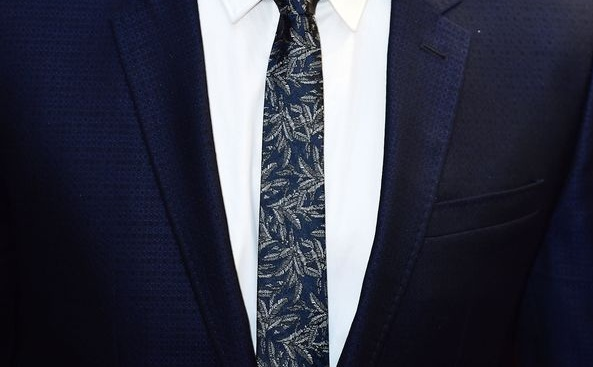

In [4]:
import base64  # Для роботи з кодуванням зображень у формат base64
import pandas as pd  # Для роботи з таблицями даних (DataFrame)
import os  # Для роботи з файловою системою
from PIL import Image  # Для роботи з зображеннями
from io import BytesIO  # Для роботи з байтовими потоками
from IPython.display import HTML  # Для відображення HTML у Jupyter Notebook

# Налаштування pandas для відображення повного вмісту стовпців
pd.set_option('display.max_colwidth', None)

# Функція для перетворення зображення у формат base64
def image_base64(path):
    # Відкриваємо зображення в байтовому режимі і перетворюємо в base64
    with open(path, 'rb') as image_file:
        return base64.b64encode(image_file.read()).decode()

# Форматування зображення для вставки у HTML через base64
def image_formatter(path):
    # Визначення розширення файлу і формату зображення для правильного визначення mime-типу
    extension = path.split('.')[-1].lower()
    mime_type = f"image/{'jpeg' if extension == 'jpg' else extension}"
    
    # Повертаємо HTML-код для вставки зображення
    return f'<img src="data:{mime_type};base64,{image_base64(path)}" width="150" height="150">'

# Функція для отримання метаданих зображення і створення DataFrame
def to_dataframe(image_path):
    image_data = []
    
    try:
        # Відкриваємо зображення за допомогою PIL
        with Image.open(image_path) as img:
            # Створюємо словник з метаданими зображення
            image_info = {
                'name': image_path.split('/')[-1],  # Назва зображення
                'color model': img.mode,  # Модель кольору (RGB, L і т.д.)
                'format': img.format,  # Формат зображення (JPEG, PNG і т.д.)
                'channels': len(img.getbands()),  # Кількість каналів (наприклад, 3 для RGB)
                'size (MB)': round(len(open(image_path, 'rb').read()) / (1024 * 1024), 2),  # Розмір зображення в МБ
                'width': img.width,  # Ширина зображення
                'height': img.height,  # Висота зображення
                'full path': image_path,  # Повний шлях до файлу
                'image': image_path  # Шлях для зображення, що використовуватиметься в HTML
            }
            image_data.append(image_info)  # Додаємо дані в список
    except IOError:
        return pd.DataFrame()  # Якщо не вдалося відкрити зображення, повертаємо порожній DataFrame
    
    # Перетворюємо список словників в DataFrame
    df = pd.DataFrame(image_data)
    return df

# Шлях до директорії, де зберігаються зображення
directory_path = 'C:\\Users\\david\\OneDrive\\Desktop\\KPI\\5 semestr\\Python\\Images\\'

# Суфікс для фільтрації зображень, які містять цей суфікс в назві
image_suffix = '_with_glasses.jpg'

dataframes = []  # Список для зберігання всіх DataFrame

# Перебір всіх файлів у директорії
for filename in os.listdir(directory_path):
    if filename.endswith(image_suffix):  # Фільтруємо тільки файли з потрібним суфіксом
        image_path = os.path.join(directory_path, filename)  # Отримуємо повний шлях до зображення
        dff = to_dataframe(image_path)  # Створюємо DataFrame для кожного зображення
        dataframes.append(dff)  # Додаємо DataFrame в список

# Якщо є зібрані DataFrame, об'єднуємо їх в один
if dataframes:
    final_df = pd.concat(dataframes, ignore_index=True)
else:
    final_df = pd.DataFrame()  # Якщо даних немає, створюємо порожній DataFrame

# Відображаємо фінальний DataFrame в HTML, використовуючи спеціальну функцію форматування для стовпця "image"
HTML(final_df.to_html(formatters={'image': image_formatter}, escape=False))
